In [1]:
import numpy as np
import pandas as pd

import time
from datetime import datetime

import gensim
import matplotlib.pyplot as plt

import en_nlp_utils
import model_evaluation_utils

In [2]:
# Define default source path
SRC_PATH = "src/"

start_time = datetime.now()
print("Text processing started at {}".format(start_time))

Text processing started at 2024-06-26 01:22:34.345528


In [3]:
# Load dataset
df_review = pd.read_csv(SRC_PATH + "en_hotel_review.csv")

In [4]:
# Check NULL values
en_nlp_utils.check_null(df_review, "df_review")

# Remove rows when "review_cleaned_v1" is NULL
df_review = df_review.dropna(subset=["review_cleaned_v1"]).reset_index(drop=True)

df_review:
source                     0
hotel_id                   0
hotel_name                 0
country                    0
group_name                 0
room_type                  0
stay_length                0
stay_date                  0
review_score               0
review_score_category      0
sentiment                  0
review_date                0
review_title               1
review                     0
review_cleaned_v1        143
dtype: int64
Total rows in df_review: 39974 



## 1) Applying Stratified Sampling

In [5]:
# Function for stratified sampling
def stratified_sample(df, stratify_col, frac):
    return df.groupby(stratify_col, group_keys=False).apply(lambda x: x.sample(frac=frac))

# Convert "stay_date" and "review_date" columns as datetime data type
df_review["stay_date"] = pd.to_datetime(df_review["stay_date"], format="%d/%m/%Y")

# Stratified sampling based on year and sentiment
frac = 0.20  # Sampling ratio
sampled_2022 = stratified_sample(df_review[df_review["stay_date"].dt.year == 2022], "sentiment", frac)
sampled_2023 = stratified_sample(df_review[df_review["stay_date"].dt.year == 2023], "sentiment", frac)
sampled_2024 = stratified_sample(df_review[df_review["stay_date"].dt.year == 2024], "sentiment", frac)

# Merge the sampled data
sampled_data = pd.concat([sampled_2022, sampled_2023, sampled_2024])

In [6]:
# Count number of reviews based on year and sentiment
sampled_sentiment_count = sampled_data.groupby([sampled_data["sentiment"], sampled_data["stay_date"].dt.year]).size().reset_index(name="count")
sampled_sentiment_count2 = sampled_sentiment_count.pivot_table(index="stay_date", columns="sentiment", values="count", 
                                               aggfunc="sum", margins=True, margins_name="Total")
sampled_sentiment_count2.columns.name = None
sampled_sentiment_count2

,negative,positive,Total
stay_date,,,
2022,338,1112,1450
2023,1073,4275,5348
2024,220,948,1168
Total,1631,6335,7966


## 2) Topic Modeling

### a) Helper functions

In [7]:
# Function to generate bow corpus
def generate_bow_corpus(df, target_text):
    
    documents = [en_nlp_utils.tokenize_sentence_to_words(cleaned_review) for cleaned_review in df[target_text]]
    
    bigram = gensim.models.Phrases(documents, min_count=20, threshold=20, delimiter="_") # higher threshold fewer phrases.
    bigram_model = gensim.models.phrases.Phraser(bigram)
    
    corpus_bigrams = [bigram_model[doc] for doc in documents]
    dictionary = gensim.corpora.Dictionary(corpus_bigrams)
    dictionary.filter_extremes(no_below=20, no_above=0.6)
    bow_corpus = [dictionary.doc2bow(text) for text in corpus_bigrams]
    
    return bow_corpus, corpus_bigrams, dictionary


# Function to calculate all models' coherence scores
def topic_model_coherence_plot(df, df_name, target_text, MODEL_NAMES, START_TOPIC_COUNT, END_TOPIC_COUNT):
    
    overall_coherence_df = pd.DataFrame() # Store each model's coherence scores
    model_topic_info = [] # Store each model's topic information
    
    bow_corpus, corpus_bigrams, dictionary = generate_bow_corpus(df, target_text)
    model_count = 0
    
    for MODEL_NAME in MODEL_NAMES:
        models, coherence_scores = en_nlp_utils.topic_model_coherence_generator(model_name=MODEL_NAME,
                                                                                corpus=bow_corpus,
                                                                                texts=corpus_bigrams,
                                                                                dictionary=dictionary,
                                                                                start_topic_count=START_TOPIC_COUNT,
                                                                                end_topic_count=END_TOPIC_COUNT,
                                                                                step=1,
                                                                                cpus=-1,
                                                                                print_topics=True)

        coherence_df = pd.DataFrame({"Model Name": MODEL_NAME, 
                                     "Number of Topics": range(START_TOPIC_COUNT, END_TOPIC_COUNT + 1, 1), 
                                     "Coherence Score": np.round(coherence_scores, 6),
                                     "df_name": df_name})
        coherence_df.sort_values(by=["Coherence Score"], ascending=False)
        print(coherence_df)
        
        overall_coherence_df = pd.concat([overall_coherence_df, coherence_df], axis=0)
        
        model_topics = []
        for model in models:
            num_topics = model.num_topics
            topics = [[(term, round(wt, 3)) for term, wt in model.show_topic(n, topn=10)] for n in range(num_topics)]
            
            # Determine the number of columns dynamically
            num_terms_per_topic = max(len(topic) for topic in topics)
            
            # Create a DataFrame for topics with dynamic columns and names
            topics_df = pd.DataFrame([[term if len(topic) > i else "" for i, (term, wt) in enumerate(topic)]
                                      for topic in topics],
                                     columns=[f"Term{i+1}" for i in range(num_terms_per_topic)],
                                     index=[f"Topic {t+1}" for t in range(num_topics)]).T
            
            model_topic_info.append({
                "Model Name": MODEL_NAME,
                "Number of Topics": num_topics,
                "Topics": topics_df.to_dict(orient="list"),  # Convert DataFrame to dictionary
                "df_name": df_name
            })
        
        x_ax = range(START_TOPIC_COUNT, END_TOPIC_COUNT + 1, 1)
        y_ax = coherence_scores
        plt.figure(num=model_count, figsize=(15, 12))
        plt.plot(x_ax, y_ax, c="r")
        plt.axhline(y=0.3, c="k", linestyle="--", linewidth=2)
        plt.axhline(y=0.4, c="k", linestyle="--", linewidth=2)
        plt.axhline(y=0.5, c="k", linestyle="--", linewidth=2)
        plt.rcParams["figure.facecolor"] = "white"
        xl = plt.xlabel("Number of Topics")
        yl = plt.ylabel("Coherence Score")

        model_count += 1

    plt.show()
    return overall_coherence_df, model_topic_info


# Function to print best model's topics
def print_best_model_topics(overall_coherence_best_df, model_topic_info_list):
    
    for index, row in overall_coherence_best_df.iterrows():
        model_name = row["Model Name"]
        num_topics = row["Number of Topics"]
        df_name = row["df_name"]
        
        print(f"\nDF NAME: {df_name}\nMODEL: {model_name} - NUMBER OF TOPICS: {num_topics}")
       
        # Find the corresponding model_topic_info
        for model_topic_info in model_topic_info_list:
            for model_info in model_topic_info:
                if (model_info["Model Name"] == model_name and
                    model_info["Number of Topics"] == num_topics and
                    model_info["df_name"] == df_name):
                    
                    topics = model_info["Topics"]
                    for topic_num, terms in topics.items():
                        print(f"\n{topic_num}: {', '.join(terms)}")
                        
                    print("\n----------\n")
                    break

### b) Topic Modeling

In [8]:
# Filter positive and negative reviews and save into different dataframe
df_pos = sampled_data[sampled_data["sentiment"] == "positive"].reset_index(drop=True)
df_neg = sampled_data[sampled_data["sentiment"] == "negative"].reset_index(drop=True)

In [9]:
MODEL_NAMES = ["LSI", "LDA"]
START_TOPIC_COUNT = 2
END_TOPIC_COUNT = 10

df_sets = [df_pos, df_neg]
df_names = ["df_pos", "df_neg"]


DF NAME: df_pos



  0%|                                                                                            | 0/9 [00:00<?, ?it/s]


MODEL: LSI - NUMBER OF TOPICS: 2


 11%|█████████▏                                                                         | 1/9 [01:43<13:50, 103.84s/it]

Topic #1:
0.514*"I" + 0.465*"room" + 0.341*"hotel" + 0.215*"stay" + 0.192*"good" + 0.182*"staff" + 0.156*"location" + 0.145*"clean" + 0.092*"get" + 0.092*"check" + 0.088*"great" + 0.087*"small" + 0.084*"bed" + 0.083*"also" + 0.075*"nice" + 0.073*"night" + 0.071*"place" + 0.069*"time" + 0.069*"one" + 0.067*"would"

Topic #2:
-0.801*"I" + 0.332*"room" + 0.240*"good" + 0.194*"location" + 0.167*"hotel" + 0.161*"clean" + 0.104*"great" + 0.094*"small" + 0.090*"staff" + 0.067*"nice" + 0.064*"near" + 0.062*"meet" + 0.055*"friendly" + -0.048*"ask" + 0.045*"food" + 0.044*"place" + 0.038*"close" + 0.037*"breakfast" + 0.036*"restaurant" + 0.035*"also"

--------------------------------------------------

MODEL: LSI - NUMBER OF TOPICS: 3


 22%|██████████████████▍                                                                | 2/9 [03:31<12:21, 105.96s/it]

Topic #1:
0.515*"I" + 0.466*"room" + 0.339*"hotel" + 0.215*"stay" + 0.192*"good" + 0.182*"staff" + 0.155*"location" + 0.145*"clean" + 0.092*"get" + 0.092*"check" + 0.088*"great" + 0.087*"small" + 0.084*"bed" + 0.083*"also" + 0.075*"nice" + 0.073*"night" + 0.071*"place" + 0.069*"time" + 0.069*"one" + 0.067*"would"

Topic #2:
-0.799*"I" + 0.296*"room" + 0.258*"good" + 0.207*"location" + 0.187*"hotel" + 0.157*"clean" + 0.108*"great" + 0.097*"staff" + 0.087*"small" + 0.068*"nice" + 0.067*"near" + 0.064*"meet" + 0.059*"friendly" + -0.050*"ask" + 0.048*"food" + 0.047*"place" + 0.041*"close" + 0.039*"breakfast" + 0.038*"restaurant" + 0.037*"stay"

Topic #3:
-0.697*"room" + 0.565*"hotel" + 0.218*"good" + 0.163*"stay" + 0.159*"location" + -0.096*"small" + 0.092*"staff" + 0.070*"singapore" + -0.070*"bed" + 0.065*"great" + 0.057*"friendly" + -0.046*"book" + 0.046*"meet" + -0.043*"clean" + 0.041*"near" + 0.040*"would" + -0.040*"check" + 0.039*"food" + 0.036*"place" + 0.036*"nice"

----------------

 33%|███████████████████████████▋                                                       | 3/9 [05:20<10:44, 107.44s/it]

Topic #1:
0.515*"I" + 0.466*"room" + 0.339*"hotel" + 0.215*"stay" + 0.192*"good" + 0.182*"staff" + 0.155*"location" + 0.145*"clean" + 0.092*"get" + 0.092*"check" + 0.088*"great" + 0.087*"small" + 0.084*"bed" + 0.083*"also" + 0.075*"nice" + 0.073*"night" + 0.071*"place" + 0.069*"time" + 0.069*"one" + 0.067*"would"

Topic #2:
-0.800*"I" + 0.291*"room" + 0.254*"good" + 0.207*"location" + 0.196*"hotel" + 0.157*"clean" + 0.109*"great" + 0.097*"staff" + 0.087*"small" + 0.068*"nice" + 0.067*"near" + 0.065*"meet" + 0.060*"friendly" + -0.050*"ask" + 0.048*"food" + 0.046*"place" + 0.041*"close" + 0.039*"stay" + 0.038*"restaurant" + 0.038*"breakfast"

Topic #3:
-0.701*"room" + 0.561*"hotel" + 0.207*"good" + 0.165*"stay" + 0.164*"location" + -0.097*"small" + 0.094*"staff" + -0.072*"bed" + 0.072*"great" + 0.069*"singapore" + 0.058*"friendly" + 0.047*"meet" + -0.047*"book" + -0.043*"clean" + 0.042*"near" + 0.040*"I" + -0.040*"check" + 0.040*"food" + 0.038*"would" + 0.036*"place"

Topic #4:
-0.658*"h

 44%|████████████████████████████████████▉                                              | 4/9 [07:09<09:00, 108.04s/it]

Topic #1:
0.515*"I" + 0.466*"room" + 0.339*"hotel" + 0.214*"stay" + 0.192*"good" + 0.182*"staff" + 0.155*"location" + 0.145*"clean" + 0.092*"get" + 0.092*"check" + 0.088*"great" + 0.087*"small" + 0.084*"bed" + 0.083*"also" + 0.075*"nice" + 0.073*"night" + 0.071*"place" + 0.069*"time" + 0.069*"one" + 0.067*"would"

Topic #2:
-0.800*"I" + 0.293*"room" + 0.253*"good" + 0.207*"location" + 0.189*"hotel" + 0.158*"clean" + 0.111*"great" + 0.099*"staff" + 0.086*"small" + 0.069*"nice" + 0.066*"near" + 0.064*"meet" + 0.061*"friendly" + -0.050*"ask" + 0.047*"food" + 0.046*"place" + 0.046*"stay" + 0.041*"close" + 0.037*"restaurant" + 0.037*"breakfast"

Topic #3:
-0.700*"room" + 0.562*"hotel" + 0.206*"good" + 0.169*"location" + 0.161*"stay" + -0.097*"small" + 0.090*"staff" + 0.074*"great" + -0.071*"bed" + 0.070*"singapore" + 0.056*"friendly" + 0.048*"meet" + -0.046*"book" + -0.045*"clean" + 0.043*"near" + 0.042*"food" + -0.042*"check" + 0.038*"place" + 0.037*"would" + 0.037*"I"

Topic #4:
-0.638*"h

 56%|██████████████████████████████████████████████                                     | 5/9 [09:07<07:27, 111.82s/it]

Topic #1:
0.515*"I" + 0.466*"room" + 0.339*"hotel" + 0.214*"stay" + 0.192*"good" + 0.182*"staff" + 0.156*"location" + 0.145*"clean" + 0.092*"get" + 0.092*"check" + 0.088*"great" + 0.087*"small" + 0.084*"bed" + 0.083*"also" + 0.075*"nice" + 0.073*"night" + 0.071*"place" + 0.069*"time" + 0.069*"one" + 0.067*"would"

Topic #2:
-0.800*"I" + 0.294*"room" + 0.256*"good" + 0.206*"location" + 0.188*"hotel" + 0.158*"clean" + 0.109*"great" + 0.097*"staff" + 0.086*"small" + 0.069*"nice" + 0.066*"near" + 0.064*"meet" + 0.060*"friendly" + 0.052*"stay" + -0.049*"ask" + 0.047*"food" + 0.046*"place" + 0.041*"close" + 0.037*"restaurant" + 0.037*"breakfast"

Topic #3:
-0.701*"room" + 0.561*"hotel" + 0.204*"good" + 0.168*"location" + 0.165*"stay" + -0.097*"small" + 0.089*"staff" + 0.075*"great" + -0.071*"bed" + 0.070*"singapore" + 0.056*"friendly" + 0.048*"meet" + -0.045*"book" + -0.045*"clean" + 0.043*"near" + 0.043*"food" + -0.043*"check" + 0.039*"place" + 0.038*"would" + 0.036*"I"

Topic #4:
-0.639*"h

 67%|███████████████████████████████████████████████████████▎                           | 6/9 [11:03<05:39, 113.19s/it]

Topic #1:
0.515*"I" + 0.466*"room" + 0.339*"hotel" + 0.214*"stay" + 0.192*"good" + 0.182*"staff" + 0.156*"location" + 0.145*"clean" + 0.092*"get" + 0.092*"check" + 0.088*"great" + 0.087*"small" + 0.084*"bed" + 0.083*"also" + 0.075*"nice" + 0.073*"night" + 0.071*"place" + 0.069*"time" + 0.069*"one" + 0.067*"would"

Topic #2:
-0.800*"I" + 0.295*"room" + 0.255*"good" + 0.208*"location" + 0.188*"hotel" + 0.157*"clean" + 0.109*"great" + 0.097*"staff" + 0.086*"small" + 0.068*"nice" + 0.066*"near" + 0.064*"meet" + 0.060*"friendly" + 0.051*"stay" + -0.049*"ask" + 0.047*"food" + 0.045*"place" + 0.041*"close" + 0.038*"restaurant" + 0.037*"breakfast"

Topic #3:
-0.702*"room" + 0.561*"hotel" + 0.207*"good" + 0.165*"location" + 0.164*"stay" + -0.097*"small" + 0.091*"staff" + 0.072*"great" + -0.071*"bed" + 0.070*"singapore" + 0.056*"friendly" + 0.048*"meet" + -0.045*"book" + -0.044*"clean" + 0.043*"near" + 0.042*"food" + -0.042*"check" + 0.040*"place" + 0.038*"would" + 0.036*"I"

Topic #4:
-0.642*"h

 78%|████████████████████████████████████████████████████████████████▌                  | 7/9 [12:57<03:46, 113.40s/it]

Topic #1:
0.516*"I" + 0.466*"room" + 0.339*"hotel" + 0.214*"stay" + 0.192*"good" + 0.182*"staff" + 0.155*"location" + 0.145*"clean" + 0.092*"get" + 0.092*"check" + 0.088*"great" + 0.087*"small" + 0.084*"bed" + 0.083*"also" + 0.075*"nice" + 0.073*"night" + 0.071*"place" + 0.069*"time" + 0.068*"one" + 0.067*"would"

Topic #2:
-0.800*"I" + 0.295*"room" + 0.256*"good" + 0.207*"location" + 0.189*"hotel" + 0.156*"clean" + 0.108*"great" + 0.098*"staff" + 0.087*"small" + 0.069*"nice" + 0.066*"near" + 0.064*"meet" + 0.060*"friendly" + 0.050*"stay" + -0.049*"ask" + 0.047*"food" + 0.046*"place" + 0.041*"close" + 0.038*"restaurant" + 0.037*"breakfast"

Topic #3:
-0.701*"room" + 0.561*"hotel" + 0.207*"good" + 0.165*"location" + 0.165*"stay" + -0.097*"small" + 0.090*"staff" + -0.071*"bed" + 0.070*"singapore" + 0.070*"great" + 0.056*"friendly" + 0.048*"meet" + -0.045*"book" + -0.045*"clean" + 0.043*"near" + 0.042*"food" + -0.042*"check" + 0.039*"place" + 0.038*"would" + 0.036*"I"

Topic #4:
-0.644*"h

 89%|█████████████████████████████████████████████████████████████████████████▊         | 8/9 [14:51<01:53, 113.64s/it]

Topic #1:
0.516*"I" + 0.466*"room" + 0.339*"hotel" + 0.214*"stay" + 0.192*"good" + 0.182*"staff" + 0.156*"location" + 0.145*"clean" + 0.092*"get" + 0.092*"check" + 0.088*"great" + 0.087*"small" + 0.084*"bed" + 0.083*"also" + 0.075*"nice" + 0.073*"night" + 0.071*"place" + 0.069*"time" + 0.068*"one" + 0.067*"would"

Topic #2:
-0.800*"I" + 0.296*"room" + 0.256*"good" + 0.206*"location" + 0.189*"hotel" + 0.157*"clean" + 0.108*"great" + 0.098*"staff" + 0.087*"small" + 0.068*"nice" + 0.066*"near" + 0.064*"meet" + 0.060*"friendly" + 0.050*"stay" + -0.049*"ask" + 0.047*"food" + 0.046*"place" + 0.041*"close" + 0.038*"restaurant" + 0.037*"breakfast"

Topic #3:
-0.701*"room" + 0.561*"hotel" + 0.206*"good" + 0.169*"location" + 0.167*"stay" + -0.097*"small" + 0.089*"staff" + -0.072*"bed" + 0.070*"singapore" + 0.070*"great" + 0.055*"friendly" + 0.049*"meet" + -0.048*"clean" + 0.045*"near" + -0.045*"book" + 0.042*"food" + -0.041*"check" + 0.039*"place" + 0.037*"would" + 0.036*"nice"

Topic #4:
-0.645

100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [16:47<00:00, 111.91s/it]


Topic #1:
0.515*"I" + 0.466*"room" + 0.339*"hotel" + 0.214*"stay" + 0.192*"good" + 0.182*"staff" + 0.156*"location" + 0.145*"clean" + 0.092*"get" + 0.092*"check" + 0.088*"great" + 0.087*"small" + 0.084*"bed" + 0.083*"also" + 0.075*"nice" + 0.073*"night" + 0.071*"place" + 0.069*"time" + 0.068*"one" + 0.067*"would"

Topic #2:
-0.800*"I" + 0.295*"room" + 0.256*"good" + 0.207*"location" + 0.189*"hotel" + 0.158*"clean" + 0.109*"great" + 0.098*"staff" + 0.087*"small" + 0.068*"nice" + 0.065*"near" + 0.064*"meet" + 0.060*"friendly" + 0.050*"stay" + -0.049*"ask" + 0.047*"food" + 0.044*"place" + 0.041*"close" + 0.037*"breakfast" + 0.037*"restaurant"

Topic #3:
-0.701*"room" + 0.561*"hotel" + 0.208*"good" + 0.167*"stay" + 0.167*"location" + -0.098*"small" + 0.090*"staff" + 0.071*"great" + -0.070*"bed" + 0.070*"singapore" + 0.056*"friendly" + -0.048*"clean" + 0.047*"meet" + -0.044*"book" + 0.042*"near" + 0.042*"food" + -0.040*"check" + 0.039*"place" + 0.038*"would" + 0.035*"I"

Topic #4:
-0.645*"h

  0%|                                                                                            | 0/9 [00:00<?, ?it/s]


MODEL: LDA - NUMBER OF TOPICS: 2


 11%|█████████▎                                                                          | 1/9 [00:06<00:54,  6.80s/it]

Topic #1:
0.043*"hotel" + 0.038*"I" + 0.033*"good" + 0.029*"room" + 0.027*"stay" + 0.021*"location" + 0.014*"clean" + 0.011*"staff" + 0.010*"meet" + 0.009*"get" + 0.009*"night" + 0.008*"also" + 0.008*"would" + 0.008*"nice" + 0.008*"place" + 0.007*"singapore" + 0.007*"bed" + 0.007*"near" + 0.007*"price" + 0.007*"time"

Topic #2:
0.050*"room" + 0.034*"staff" + 0.026*"location" + 0.025*"great" + 0.020*"clean" + 0.015*"stay" + 0.014*"hotel" + 0.014*"I" + 0.014*"good" + 0.013*"friendly" + 0.013*"nice" + 0.012*"small" + 0.010*"place" + 0.009*"near" + 0.008*"helpful" + 0.008*"service" + 0.008*"check" + 0.007*"breakfast" + 0.007*"pool" + 0.007*"restaurant"

--------------------------------------------------

MODEL: LDA - NUMBER OF TOPICS: 3


 22%|██████████████████▋                                                                 | 2/9 [00:13<00:48,  6.94s/it]

Topic #1:
0.047*"room" + 0.043*"hotel" + 0.039*"location" + 0.038*"good" + 0.023*"clean" + 0.021*"staff" + 0.021*"great" + 0.016*"stay" + 0.013*"near" + 0.013*"nice" + 0.012*"small" + 0.011*"breakfast" + 0.010*"meet" + 0.009*"food" + 0.008*"I" + 0.007*"friendly" + 0.007*"comfortable" + 0.007*"price" + 0.006*"area" + 0.006*"meet_station"

Topic #2:
0.030*"room" + 0.028*"I" + 0.028*"stay" + 0.021*"staff" + 0.020*"good" + 0.019*"hotel" + 0.014*"place" + 0.013*"location" + 0.012*"also" + 0.011*"clean" + 0.010*"night" + 0.009*"nice" + 0.009*"friendly" + 0.008*"bed" + 0.008*"great" + 0.008*"need" + 0.008*"check" + 0.007*"get" + 0.007*"day" + 0.007*"time"

Topic #3:
0.066*"I" + 0.036*"room" + 0.024*"hotel" + 0.021*"stay" + 0.021*"staff" + 0.013*"clean" + 0.012*"check" + 0.010*"location" + 0.009*"friendly" + 0.009*"would" + 0.009*"small" + 0.008*"get" + 0.008*"bed" + 0.007*"like" + 0.007*"time" + 0.007*"one" + 0.007*"helpful" + 0.007*"well" + 0.007*"recommend" + 0.007*"pool"

-----------------

 33%|████████████████████████████                                                        | 3/9 [00:19<00:39,  6.54s/it]

Topic #1:
0.068*"I" + 0.035*"stay" + 0.030*"hotel" + 0.029*"staff" + 0.021*"room" + 0.015*"check" + 0.014*"nice" + 0.010*"would" + 0.009*"place" + 0.009*"get" + 0.009*"also" + 0.009*"night" + 0.009*"time" + 0.008*"good" + 0.008*"book" + 0.008*"breakfast" + 0.008*"really" + 0.007*"singapore" + 0.007*"friendly" + 0.007*"need"

Topic #2:
0.060*"room" + 0.027*"hotel" + 0.025*"I" + 0.016*"small" + 0.014*"stay" + 0.013*"clean" + 0.010*"good" + 0.010*"shower" + 0.008*"get" + 0.008*"bed" + 0.008*"one" + 0.007*"location" + 0.007*"bathroom" + 0.007*"well" + 0.006*"also" + 0.006*"check" + 0.006*"floor" + 0.006*"toilet" + 0.006*"water" + 0.006*"make"

Topic #3:
0.048*"location" + 0.046*"hotel" + 0.042*"good" + 0.024*"great" + 0.022*"room" + 0.022*"staff" + 0.021*"stay" + 0.019*"near" + 0.016*"clean" + 0.016*"meet" + 0.013*"place" + 0.012*"I" + 0.010*"food" + 0.010*"friendly" + 0.010*"nice" + 0.009*"close" + 0.008*"singapore" + 0.007*"meet_station" + 0.007*"price" + 0.007*"restaurant"

Topic #4:
0.

 44%|█████████████████████████████████████▎                                              | 4/9 [00:26<00:32,  6.43s/it]

Topic #1:
0.050*"staff" + 0.039*"hotel" + 0.028*"stay" + 0.027*"I" + 0.027*"room" + 0.026*"friendly" + 0.026*"location" + 0.025*"clean" + 0.025*"good" + 0.018*"helpful" + 0.014*"great" + 0.009*"close" + 0.009*"service" + 0.008*"nice" + 0.007*"place" + 0.007*"time" + 0.007*"thank" + 0.007*"breakfast" + 0.007*"excellent" + 0.006*"check"

Topic #2:
0.048*"location" + 0.032*"good" + 0.027*"hotel" + 0.026*"near" + 0.026*"stay" + 0.025*"room" + 0.024*"great" + 0.024*"clean" + 0.024*"meet" + 0.017*"food" + 0.016*"nice" + 0.013*"place" + 0.010*"staff" + 0.009*"restaurant" + 0.009*"close" + 0.009*"lot" + 0.009*"nearby" + 0.009*"breakfast" + 0.009*"night" + 0.008*"convenient"

Topic #3:
0.054*"room" + 0.030*"hotel" + 0.028*"I" + 0.016*"bed" + 0.016*"clean" + 0.012*"small" + 0.012*"staff" + 0.012*"stay" + 0.011*"get" + 0.011*"great" + 0.010*"also" + 0.009*"need" + 0.009*"shower" + 0.008*"one" + 0.008*"night" + 0.008*"place" + 0.007*"location" + 0.007*"well" + 0.007*"nice" + 0.007*"singapore"

Top

 56%|██████████████████████████████████████████████▋                                     | 5/9 [00:32<00:25,  6.27s/it]

Topic #1:
0.037*"room" + 0.028*"clean" + 0.016*"also" + 0.014*"I" + 0.013*"bed" + 0.012*"hotel" + 0.012*"coffee" + 0.012*"one" + 0.011*"water" + 0.011*"day" + 0.011*"breakfast" + 0.011*"location" + 0.010*"bathroom" + 0.010*"stay" + 0.010*"use" + 0.010*"need" + 0.009*"floor" + 0.008*"good" + 0.008*"staff" + 0.008*"area"

Topic #2:
0.056*"location" + 0.047*"hotel" + 0.039*"room" + 0.037*"good" + 0.033*"great" + 0.026*"staff" + 0.020*"near" + 0.019*"stay" + 0.017*"clean" + 0.016*"meet" + 0.011*"food" + 0.011*"friendly" + 0.011*"nice" + 0.010*"small" + 0.009*"price" + 0.009*"restaurant" + 0.008*"close" + 0.008*"nearby" + 0.008*"comfortable" + 0.008*"helpful"

Topic #3:
0.044*"I" + 0.024*"room" + 0.024*"good" + 0.022*"location" + 0.020*"hotel" + 0.013*"place" + 0.013*"night" + 0.012*"stay" + 0.012*"check" + 0.012*"meet" + 0.012*"go" + 0.010*"also" + 0.010*"staff" + 0.008*"clean" + 0.008*"food" + 0.008*"singapore" + 0.008*"price" + 0.008*"everything" + 0.007*"bed" + 0.007*"near"

Topic #4:
0

 67%|████████████████████████████████████████████████████████                            | 6/9 [00:38<00:18,  6.28s/it]

Topic #1:
0.090*"good" + 0.056*"staff" + 0.055*"location" + 0.027*"clean" + 0.023*"helpful" + 0.022*"friendly" + 0.020*"room" + 0.020*"near" + 0.019*"place" + 0.018*"hotel" + 0.018*"excellent" + 0.016*"food" + 0.015*"nice" + 0.013*"shopping" + 0.013*"meet" + 0.013*"city" + 0.012*"locate" + 0.012*"nearby" + 0.011*"centre" + 0.011*"close"

Topic #2:
0.069*"room" + 0.024*"I" + 0.021*"clean" + 0.018*"hotel" + 0.018*"bed" + 0.015*"staff" + 0.013*"small" + 0.011*"location" + 0.011*"stay" + 0.010*"nice" + 0.010*"good" + 0.010*"get" + 0.009*"bathroom" + 0.009*"night" + 0.008*"shower" + 0.008*"check" + 0.008*"like" + 0.007*"toilet" + 0.007*"floor" + 0.007*"book"

Topic #3:
0.040*"staff" + 0.034*"hotel" + 0.033*"room" + 0.033*"I" + 0.016*"breakfast" + 0.014*"clean" + 0.012*"stay" + 0.010*"friendly" + 0.010*"great" + 0.010*"wonderful" + 0.010*"even" + 0.010*"pretty" + 0.010*"check" + 0.009*"time" + 0.009*"lovely" + 0.009*"place" + 0.008*"make" + 0.008*"good" + 0.008*"accommodation" + 0.008*"thank

 78%|█████████████████████████████████████████████████████████████████▎                  | 7/9 [00:44<00:12,  6.19s/it]

Topic #1:
0.030*"I" + 0.028*"room" + 0.023*"hotel" + 0.022*"staff" + 0.017*"stay" + 0.014*"night" + 0.014*"one" + 0.013*"get" + 0.013*"bed" + 0.009*"good" + 0.009*"location" + 0.009*"like" + 0.008*"helpful" + 0.008*"food" + 0.007*"friendly" + 0.007*"would" + 0.007*"day" + 0.007*"could" + 0.007*"use" + 0.007*"singapore"

Topic #2:
0.064*"room" + 0.059*"I" + 0.024*"hotel" + 0.017*"stay" + 0.013*"check" + 0.013*"small" + 0.013*"clean" + 0.011*"staff" + 0.010*"get" + 0.009*"bed" + 0.009*"book" + 0.008*"floor" + 0.007*"like" + 0.007*"bathroom" + 0.007*"would" + 0.007*"even" + 0.007*"well" + 0.007*"great" + 0.007*"good" + 0.006*"make"

Topic #3:
0.059*"location" + 0.046*"good" + 0.039*"room" + 0.023*"I" + 0.020*"clean" + 0.016*"stay" + 0.015*"great" + 0.015*"night" + 0.012*"meet" + 0.012*"hotel" + 0.012*"toilet" + 0.011*"also" + 0.009*"provide" + 0.008*"place" + 0.008*"would" + 0.008*"recommend" + 0.008*"shower" + 0.008*"comfortable" + 0.008*"water" + 0.007*"near"

Topic #4:
0.026*"stay" + 0

 89%|██████████████████████████████████████████████████████████████████████████▋         | 8/9 [00:50<00:06,  6.10s/it]

Topic #1:
0.061*"staff" + 0.043*"nice" + 0.038*"room" + 0.032*"clean" + 0.023*"stay" + 0.021*"helpful" + 0.019*"location" + 0.018*"friendly" + 0.016*"I" + 0.015*"check" + 0.013*"excellent" + 0.013*"service" + 0.012*"place" + 0.012*"good" + 0.010*"everything" + 0.009*"great" + 0.009*"near" + 0.008*"also" + 0.008*"need" + 0.007*"convenient"

Topic #2:
0.075*"room" + 0.031*"hotel" + 0.022*"I" + 0.020*"clean" + 0.016*"small" + 0.016*"staff" + 0.013*"stay" + 0.012*"location" + 0.011*"water" + 0.011*"good" + 0.011*"also" + 0.008*"near" + 0.008*"bed" + 0.007*"size" + 0.007*"give" + 0.007*"even" + 0.007*"day" + 0.006*"friendly" + 0.006*"spacious" + 0.006*"book"

Topic #3:
0.063*"I" + 0.042*"room" + 0.027*"hotel" + 0.018*"stay" + 0.015*"good" + 0.011*"staff" + 0.011*"location" + 0.011*"check" + 0.009*"get" + 0.009*"one" + 0.008*"bed" + 0.008*"really" + 0.008*"night" + 0.008*"also" + 0.008*"small" + 0.007*"well" + 0.007*"clean" + 0.007*"would" + 0.007*"bit" + 0.007*"could"

Topic #4:
0.089*"good

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:56<00:00,  6.25s/it]

Topic #1:
0.063*"hotel" + 0.063*"location" + 0.041*"near" + 0.040*"staff" + 0.030*"good" + 0.024*"meet" + 0.024*"great" + 0.019*"room" + 0.018*"helpful" + 0.014*"close" + 0.014*"clean" + 0.014*"place" + 0.014*"friendly" + 0.014*"station" + 0.013*"perfect" + 0.012*"meet_station" + 0.012*"everything" + 0.010*"convenient" + 0.010*"boris" + 0.009*"strategic"

Topic #2:
0.033*"room" + 0.023*"hotel" + 0.019*"location" + 0.018*"great" + 0.016*"food" + 0.015*"staff" + 0.013*"also" + 0.012*"stay" + 0.012*"near" + 0.012*"good" + 0.011*"restaurant" + 0.010*"breakfast" + 0.010*"meet" + 0.010*"clean" + 0.009*"option" + 0.009*"service" + 0.009*"around" + 0.008*"lovely" + 0.008*"city" + 0.008*"lot"

Topic #3:
0.043*"hotel" + 0.020*"location" + 0.019*"room" + 0.017*"stay" + 0.017*"place" + 0.017*"great" + 0.014*"nearby" + 0.013*"area" + 0.013*"meet" + 0.013*"clean" + 0.012*"I" + 0.012*"night" + 0.012*"close" + 0.011*"chinatown" + 0.011*"singapore" + 0.010*"good" + 0.010*"meet_station" + 0.010*"check" 

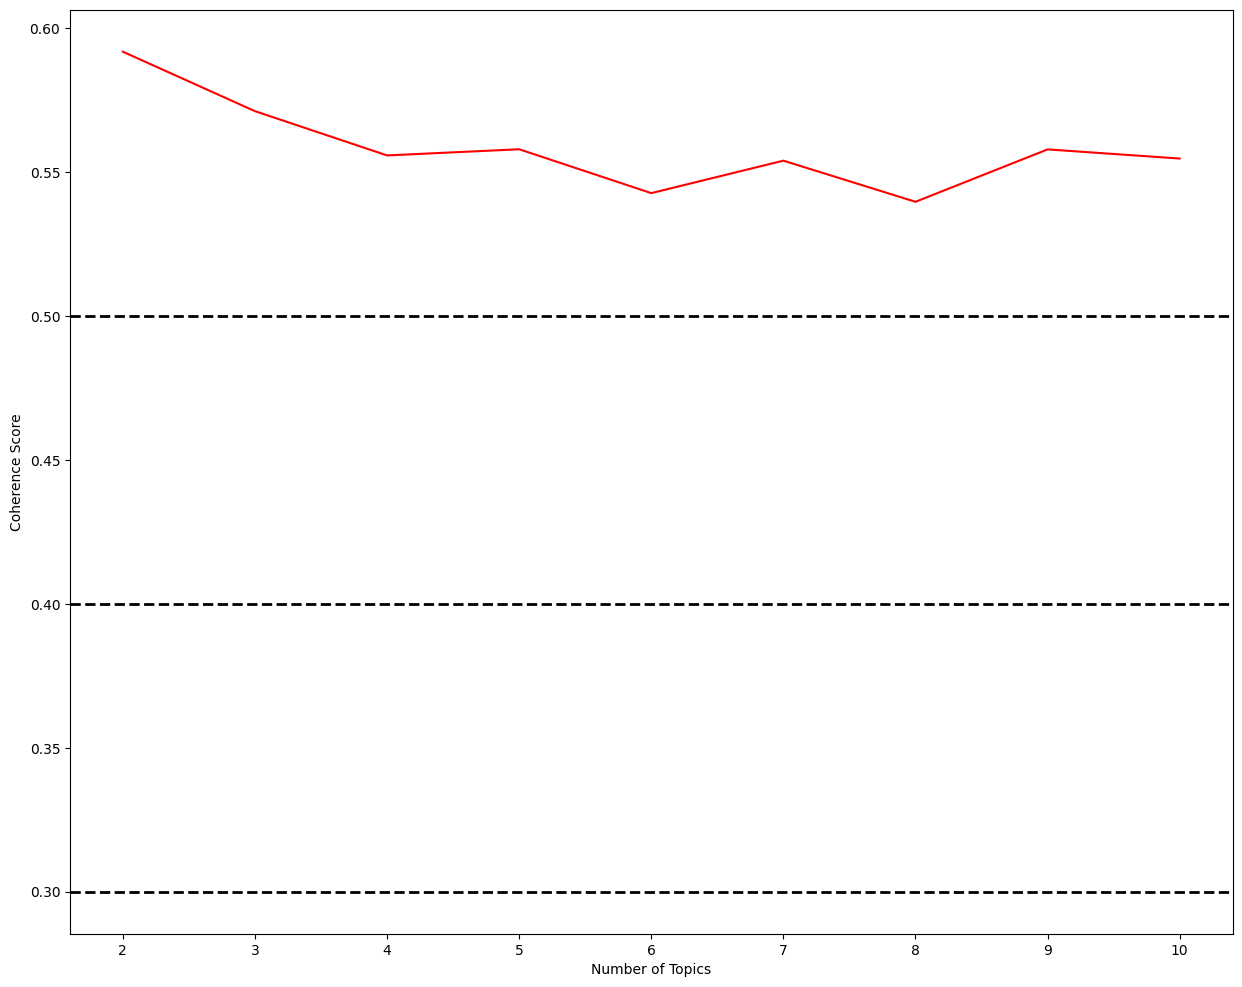

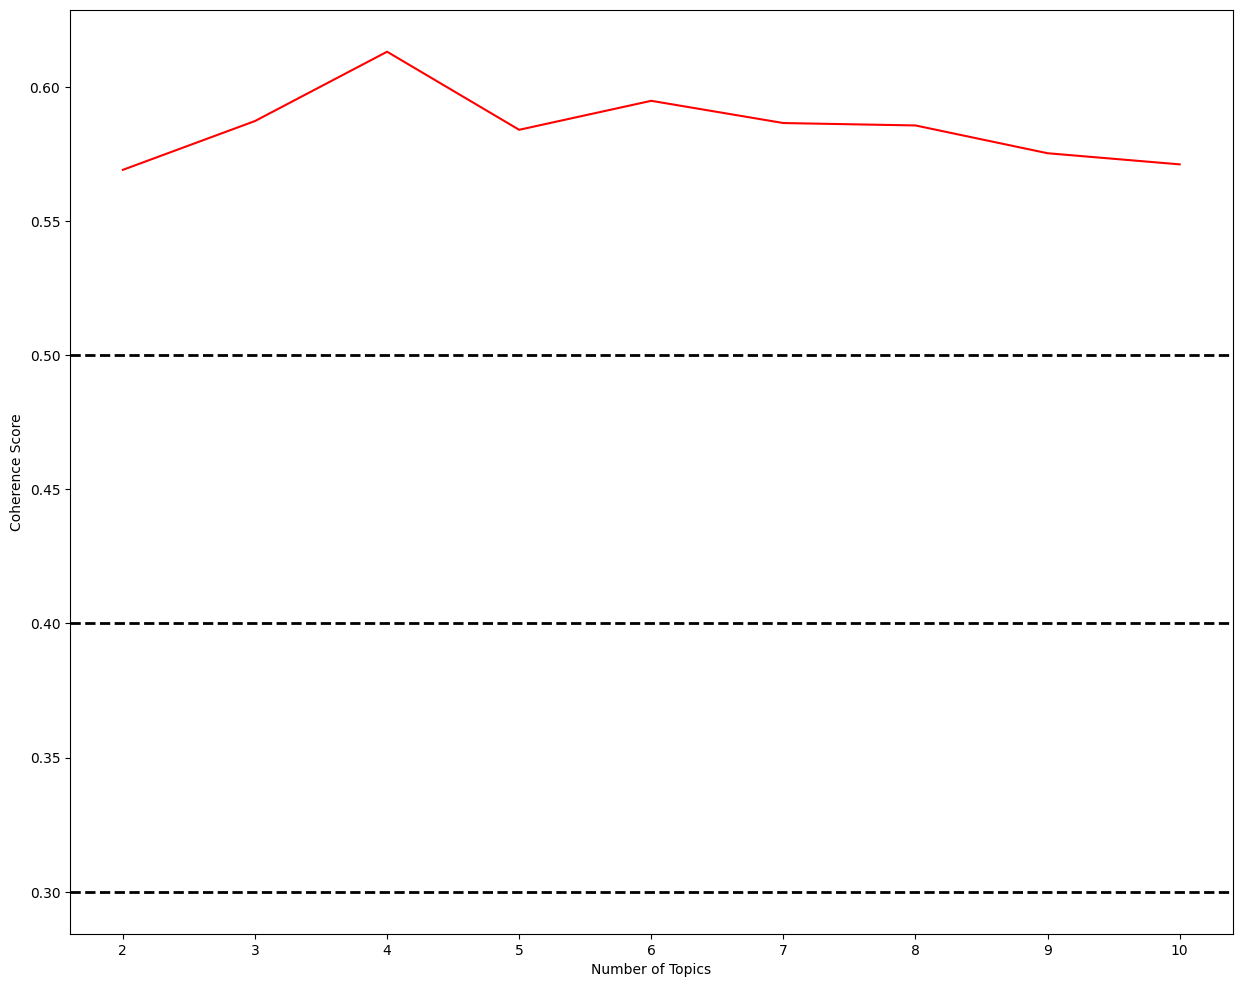


DF NAME: df_neg



  0%|                                                                                            | 0/9 [00:00<?, ?it/s]


MODEL: LSI - NUMBER OF TOPICS: 2


 11%|█████████▎                                                                          | 1/9 [00:20<02:47, 20.91s/it]

Topic #1:
0.652*"I" + 0.497*"room" + 0.269*"hotel" + 0.145*"stay" + 0.126*"staff" + 0.124*"check" + 0.090*"one" + 0.084*"night" + 0.084*"get" + 0.081*"go" + 0.078*"time" + 0.074*"book" + 0.074*"ask" + 0.070*"pay" + 0.067*"even" + 0.065*"say" + 0.065*"clean" + 0.065*"bed" + 0.064*"day" + 0.061*"reception"

Topic #2:
0.677*"room" + -0.674*"I" + 0.098*"small" + 0.082*"hotel" + 0.063*"night" + 0.059*"staff" + 0.059*"good" + 0.059*"well" + 0.058*"towel" + 0.048*"clean" + 0.043*"location" + 0.043*"smell" + 0.042*"get" + 0.041*"change" + 0.039*"dirty" + 0.038*"day" + 0.037*"shower" + -0.037*"pay" + 0.036*"even" + 0.035*"bathroom"

--------------------------------------------------

MODEL: LSI - NUMBER OF TOPICS: 3


 22%|██████████████████▋                                                                 | 2/9 [00:42<02:28, 21.17s/it]

Topic #1:
0.652*"I" + 0.497*"room" + 0.269*"hotel" + 0.145*"stay" + 0.126*"staff" + 0.124*"check" + 0.090*"one" + 0.084*"night" + 0.084*"get" + 0.081*"go" + 0.078*"time" + 0.074*"book" + 0.074*"ask" + 0.070*"pay" + 0.067*"even" + 0.065*"say" + 0.065*"clean" + 0.065*"bed" + 0.064*"day" + 0.061*"reception"

Topic #2:
0.677*"room" + -0.674*"I" + 0.098*"small" + 0.082*"hotel" + 0.063*"night" + 0.059*"staff" + 0.059*"good" + 0.059*"well" + 0.058*"towel" + 0.048*"clean" + 0.043*"location" + 0.043*"smell" + 0.042*"get" + 0.041*"change" + 0.039*"dirty" + 0.038*"day" + 0.037*"shower" + -0.037*"pay" + 0.036*"even" + 0.035*"bathroom"

Topic #3:
0.799*"hotel" + -0.392*"room" + -0.234*"I" + 0.182*"staff" + 0.099*"stay" + 0.080*"good" + 0.072*"guest" + 0.067*"really" + 0.065*"day" + 0.064*"location" + 0.059*"get" + 0.058*"price" + 0.057*"go" + 0.055*"need" + 0.054*"service" + 0.054*"bad" + 0.053*"check" + 0.051*"star" + 0.049*"breakfast" + 0.044*"lobby"

---------------------------------------------

 33%|████████████████████████████                                                        | 3/9 [01:03<02:08, 21.35s/it]

Topic #1:
0.652*"I" + 0.497*"room" + 0.269*"hotel" + 0.145*"stay" + 0.126*"staff" + 0.124*"check" + 0.090*"one" + 0.084*"night" + 0.084*"get" + 0.081*"go" + 0.078*"time" + 0.074*"book" + 0.074*"ask" + 0.070*"pay" + 0.067*"even" + 0.065*"say" + 0.065*"clean" + 0.065*"bed" + 0.064*"day" + 0.061*"reception"

Topic #2:
0.677*"room" + -0.674*"I" + 0.098*"small" + 0.082*"hotel" + 0.063*"night" + 0.059*"staff" + 0.059*"good" + 0.059*"well" + 0.058*"towel" + 0.048*"clean" + 0.043*"location" + 0.043*"smell" + 0.042*"get" + 0.041*"change" + 0.039*"dirty" + 0.038*"day" + 0.037*"shower" + -0.037*"pay" + 0.036*"even" + 0.035*"bathroom"

Topic #3:
0.799*"hotel" + -0.392*"room" + -0.234*"I" + 0.182*"staff" + 0.099*"stay" + 0.080*"good" + 0.072*"guest" + 0.067*"really" + 0.065*"day" + 0.064*"location" + 0.059*"get" + 0.058*"price" + 0.057*"go" + 0.055*"need" + 0.054*"service" + 0.054*"bad" + 0.053*"check" + 0.051*"star" + 0.049*"breakfast" + 0.044*"lobby"

Topic #4:
-0.484*"staff" + 0.427*"hotel" + -0

 44%|█████████████████████████████████████▎                                              | 4/9 [01:25<01:47, 21.50s/it]

Topic #1:
0.652*"I" + 0.497*"room" + 0.269*"hotel" + 0.145*"stay" + 0.126*"staff" + 0.124*"check" + 0.090*"one" + 0.084*"night" + 0.084*"get" + 0.081*"go" + 0.078*"time" + 0.074*"book" + 0.074*"ask" + 0.070*"pay" + 0.067*"even" + 0.065*"say" + 0.065*"clean" + 0.065*"bed" + 0.064*"day" + 0.061*"reception"

Topic #2:
0.677*"room" + -0.674*"I" + 0.098*"small" + 0.082*"hotel" + 0.063*"night" + 0.059*"staff" + 0.059*"good" + 0.059*"well" + 0.058*"towel" + 0.048*"clean" + 0.043*"location" + 0.043*"smell" + 0.042*"get" + 0.041*"change" + 0.039*"dirty" + 0.038*"day" + 0.037*"shower" + -0.037*"pay" + 0.036*"even" + 0.035*"bathroom"

Topic #3:
0.799*"hotel" + -0.392*"room" + -0.234*"I" + 0.182*"staff" + 0.099*"stay" + 0.080*"good" + 0.072*"guest" + 0.067*"really" + 0.065*"day" + 0.064*"location" + 0.059*"get" + 0.058*"price" + 0.057*"go" + 0.055*"need" + 0.054*"service" + 0.054*"bad" + 0.053*"check" + 0.051*"star" + 0.049*"breakfast" + 0.044*"lobby"

Topic #4:
-0.484*"staff" + 0.427*"hotel" + -0

 56%|██████████████████████████████████████████████▋                                     | 5/9 [01:47<01:26, 21.71s/it]

Topic #1:
0.652*"I" + 0.497*"room" + 0.269*"hotel" + 0.145*"stay" + 0.126*"staff" + 0.124*"check" + 0.090*"one" + 0.084*"night" + 0.084*"get" + 0.081*"go" + 0.078*"time" + 0.074*"book" + 0.074*"ask" + 0.070*"pay" + 0.067*"even" + 0.065*"say" + 0.065*"clean" + 0.065*"bed" + 0.064*"day" + 0.061*"reception"

Topic #2:
0.677*"room" + -0.674*"I" + 0.098*"small" + 0.082*"hotel" + 0.063*"night" + 0.059*"staff" + 0.059*"good" + 0.059*"well" + 0.058*"towel" + 0.048*"clean" + 0.043*"location" + 0.043*"smell" + 0.042*"get" + 0.041*"change" + 0.039*"dirty" + 0.038*"day" + 0.037*"shower" + -0.037*"pay" + 0.036*"even" + 0.035*"bathroom"

Topic #3:
0.799*"hotel" + -0.392*"room" + -0.234*"I" + 0.182*"staff" + 0.099*"stay" + 0.080*"good" + 0.072*"guest" + 0.067*"really" + 0.065*"day" + 0.064*"location" + 0.059*"get" + 0.058*"price" + 0.057*"go" + 0.055*"need" + 0.054*"service" + 0.054*"bad" + 0.053*"check" + 0.051*"star" + 0.049*"breakfast" + 0.044*"lobby"

Topic #4:
-0.484*"staff" + 0.427*"hotel" + -0

 67%|████████████████████████████████████████████████████████                            | 6/9 [02:09<01:05, 21.83s/it]

Topic #1:
0.652*"I" + 0.497*"room" + 0.269*"hotel" + 0.145*"stay" + 0.126*"staff" + 0.124*"check" + 0.090*"one" + 0.084*"night" + 0.084*"get" + 0.081*"go" + 0.078*"time" + 0.074*"book" + 0.074*"ask" + 0.070*"pay" + 0.067*"even" + 0.065*"say" + 0.065*"clean" + 0.065*"bed" + 0.064*"day" + 0.061*"reception"

Topic #2:
0.677*"room" + -0.674*"I" + 0.098*"small" + 0.082*"hotel" + 0.063*"night" + 0.059*"staff" + 0.059*"good" + 0.059*"well" + 0.058*"towel" + 0.048*"clean" + 0.043*"location" + 0.043*"smell" + 0.042*"get" + 0.041*"change" + 0.039*"dirty" + 0.038*"day" + 0.037*"shower" + -0.037*"pay" + 0.036*"even" + 0.035*"bathroom"

Topic #3:
0.799*"hotel" + -0.392*"room" + -0.234*"I" + 0.182*"staff" + 0.099*"stay" + 0.080*"good" + 0.072*"guest" + 0.067*"really" + 0.065*"day" + 0.064*"location" + 0.059*"get" + 0.058*"price" + 0.057*"go" + 0.055*"need" + 0.054*"service" + 0.054*"bad" + 0.053*"check" + 0.051*"star" + 0.049*"breakfast" + 0.044*"lobby"

Topic #4:
-0.484*"staff" + 0.427*"hotel" + -0

 78%|█████████████████████████████████████████████████████████████████▎                  | 7/9 [02:32<00:44, 22.18s/it]

Topic #1:
0.652*"I" + 0.497*"room" + 0.269*"hotel" + 0.145*"stay" + 0.126*"staff" + 0.124*"check" + 0.090*"one" + 0.084*"night" + 0.084*"get" + 0.081*"go" + 0.078*"time" + 0.074*"book" + 0.074*"ask" + 0.070*"pay" + 0.067*"even" + 0.065*"say" + 0.065*"clean" + 0.065*"bed" + 0.064*"day" + 0.061*"reception"

Topic #2:
0.677*"room" + -0.674*"I" + 0.098*"small" + 0.082*"hotel" + 0.063*"night" + 0.059*"staff" + 0.059*"good" + 0.059*"well" + 0.058*"towel" + 0.048*"clean" + 0.043*"location" + 0.043*"smell" + 0.042*"get" + 0.041*"change" + 0.039*"dirty" + 0.038*"day" + 0.037*"shower" + -0.037*"pay" + 0.036*"even" + 0.035*"bathroom"

Topic #3:
0.799*"hotel" + -0.392*"room" + -0.234*"I" + 0.182*"staff" + 0.099*"stay" + 0.080*"good" + 0.072*"guest" + 0.067*"really" + 0.065*"day" + 0.064*"location" + 0.059*"get" + 0.058*"price" + 0.057*"go" + 0.055*"need" + 0.054*"service" + 0.054*"bad" + 0.053*"check" + 0.051*"star" + 0.049*"breakfast" + 0.044*"lobby"

Topic #4:
-0.484*"staff" + 0.427*"hotel" + -0

 89%|██████████████████████████████████████████████████████████████████████████▋         | 8/9 [02:56<00:22, 22.59s/it]

Topic #1:
0.652*"I" + 0.497*"room" + 0.269*"hotel" + 0.145*"stay" + 0.126*"staff" + 0.124*"check" + 0.090*"one" + 0.084*"night" + 0.084*"get" + 0.081*"go" + 0.078*"time" + 0.074*"book" + 0.074*"ask" + 0.070*"pay" + 0.067*"even" + 0.065*"say" + 0.065*"clean" + 0.065*"bed" + 0.064*"day" + 0.061*"reception"

Topic #2:
0.677*"room" + -0.674*"I" + 0.098*"small" + 0.082*"hotel" + 0.063*"night" + 0.059*"staff" + 0.059*"good" + 0.059*"well" + 0.058*"towel" + 0.048*"clean" + 0.043*"location" + 0.043*"smell" + 0.042*"get" + 0.041*"change" + 0.039*"dirty" + 0.038*"day" + 0.037*"shower" + -0.037*"pay" + 0.036*"even" + 0.035*"bathroom"

Topic #3:
0.799*"hotel" + -0.392*"room" + -0.234*"I" + 0.182*"staff" + 0.099*"stay" + 0.080*"good" + 0.072*"guest" + 0.067*"really" + 0.065*"day" + 0.064*"location" + 0.059*"get" + 0.058*"price" + 0.057*"go" + 0.055*"need" + 0.054*"service" + 0.054*"bad" + 0.053*"check" + 0.051*"star" + 0.049*"breakfast" + 0.044*"lobby"

Topic #4:
-0.484*"staff" + 0.427*"hotel" + -0

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [03:19<00:00, 22.18s/it]


Topic #1:
0.652*"I" + 0.497*"room" + 0.269*"hotel" + 0.145*"stay" + 0.126*"staff" + 0.124*"check" + 0.090*"one" + 0.084*"night" + 0.084*"get" + 0.081*"go" + 0.078*"time" + 0.074*"book" + 0.074*"ask" + 0.070*"pay" + 0.067*"even" + 0.065*"say" + 0.065*"clean" + 0.065*"bed" + 0.064*"day" + 0.061*"reception"

Topic #2:
0.677*"room" + -0.674*"I" + 0.098*"small" + 0.082*"hotel" + 0.063*"night" + 0.059*"staff" + 0.059*"good" + 0.059*"well" + 0.058*"towel" + 0.048*"clean" + 0.043*"location" + 0.043*"smell" + 0.042*"get" + 0.041*"change" + 0.039*"dirty" + 0.038*"day" + 0.037*"shower" + -0.037*"pay" + 0.036*"even" + 0.035*"bathroom"

Topic #3:
0.799*"hotel" + -0.392*"room" + -0.234*"I" + 0.182*"staff" + 0.099*"stay" + 0.080*"good" + 0.072*"guest" + 0.067*"really" + 0.065*"day" + 0.064*"location" + 0.059*"get" + 0.058*"price" + 0.057*"go" + 0.055*"need" + 0.054*"service" + 0.054*"bad" + 0.053*"check" + 0.051*"star" + 0.049*"breakfast" + 0.044*"lobby"

Topic #4:
-0.484*"staff" + 0.427*"hotel" + -0

  0%|                                                                                            | 0/9 [00:00<?, ?it/s]


MODEL: LDA - NUMBER OF TOPICS: 2


 11%|█████████▎                                                                          | 1/9 [00:06<00:51,  6.40s/it]

Topic #1:
0.069*"room" + 0.056*"I" + 0.037*"hotel" + 0.020*"staff" + 0.017*"stay" + 0.015*"check" + 0.012*"clean" + 0.012*"get" + 0.011*"good" + 0.011*"night" + 0.011*"one" + 0.010*"small" + 0.010*"even" + 0.010*"go" + 0.010*"smell" + 0.009*"bad" + 0.008*"time" + 0.008*"day" + 0.008*"book" + 0.008*"location"

Topic #2:
0.051*"room" + 0.042*"I" + 0.028*"hotel" + 0.022*"small" + 0.016*"stay" + 0.016*"bed" + 0.013*"good" + 0.013*"need" + 0.012*"time" + 0.012*"staff" + 0.011*"shower" + 0.011*"would" + 0.011*"get" + 0.011*"night" + 0.011*"breakfast" + 0.011*"nothing" + 0.010*"clean" + 0.009*"location" + 0.009*"like" + 0.009*"bathroom"

--------------------------------------------------

MODEL: LDA - NUMBER OF TOPICS: 3


 22%|██████████████████▋                                                                 | 2/9 [00:11<00:39,  5.60s/it]

Topic #1:
0.072*"room" + 0.034*"I" + 0.028*"hotel" + 0.024*"stay" + 0.017*"get" + 0.015*"time" + 0.014*"bathroom" + 0.012*"night" + 0.012*"check" + 0.012*"small" + 0.011*"shower" + 0.011*"bad" + 0.011*"one" + 0.011*"like" + 0.010*"work" + 0.010*"clean" + 0.009*"even" + 0.009*"need" + 0.009*"recommend" + 0.009*"really"

Topic #2:
0.078*"I" + 0.050*"room" + 0.035*"hotel" + 0.022*"staff" + 0.014*"check" + 0.013*"stay" + 0.011*"one" + 0.011*"night" + 0.010*"go" + 0.010*"small" + 0.010*"clean" + 0.009*"get" + 0.009*"book" + 0.009*"need" + 0.009*"even" + 0.009*"price" + 0.009*"good" + 0.009*"water" + 0.009*"nothing" + 0.009*"towel"

Topic #3:
0.078*"room" + 0.042*"hotel" + 0.026*"small" + 0.024*"good" + 0.023*"staff" + 0.021*"I" + 0.021*"location" + 0.018*"bed" + 0.018*"clean" + 0.014*"stay" + 0.012*"smell" + 0.011*"night" + 0.010*"door" + 0.009*"dirty" + 0.008*"breakfast" + 0.008*"service" + 0.008*"check" + 0.007*"get" + 0.007*"bit" + 0.007*"old"

-------------------------------------------

 33%|████████████████████████████                                                        | 3/9 [00:15<00:30,  5.01s/it]

Topic #1:
0.083*"room" + 0.072*"I" + 0.034*"hotel" + 0.018*"stay" + 0.017*"staff" + 0.014*"small" + 0.012*"one" + 0.012*"check" + 0.012*"night" + 0.011*"time" + 0.011*"book" + 0.010*"get" + 0.010*"bed" + 0.009*"need" + 0.009*"breakfast" + 0.009*"like" + 0.009*"bad" + 0.009*"go" + 0.009*"nothing" + 0.008*"bathroom"

Topic #2:
0.050*"I" + 0.024*"room" + 0.023*"staff" + 0.022*"small" + 0.022*"stay" + 0.020*"hotel" + 0.018*"good" + 0.017*"check" + 0.016*"clean" + 0.014*"bit" + 0.014*"location" + 0.013*"breakfast" + 0.012*"get" + 0.012*"really" + 0.010*"need" + 0.010*"smell" + 0.010*"night" + 0.010*"food" + 0.010*"expensive" + 0.009*"price"

Topic #3:
0.059*"room" + 0.049*"hotel" + 0.018*"staff" + 0.017*"stay" + 0.017*"I" + 0.015*"get" + 0.014*"bad" + 0.013*"also" + 0.012*"place" + 0.011*"time" + 0.011*"floor" + 0.011*"water" + 0.011*"even" + 0.010*"would" + 0.010*"good" + 0.010*"shower" + 0.010*"small" + 0.009*"charge" + 0.009*"toilet" + 0.009*"clean"

Topic #4:
0.047*"room" + 0.034*"I" + 

 44%|█████████████████████████████████████▎                                              | 4/9 [00:20<00:24,  4.85s/it]

Topic #1:
0.062*"I" + 0.043*"room" + 0.036*"hotel" + 0.017*"check" + 0.016*"get" + 0.016*"staff" + 0.015*"night" + 0.015*"stay" + 0.014*"good" + 0.012*"time" + 0.012*"recommend" + 0.012*"would" + 0.011*"clean" + 0.010*"small" + 0.009*"work" + 0.009*"one" + 0.009*"pool" + 0.009*"need" + 0.008*"could" + 0.008*"book"

Topic #2:
0.085*"room" + 0.058*"I" + 0.029*"staff" + 0.020*"check" + 0.019*"night" + 0.019*"hotel" + 0.017*"small" + 0.017*"stay" + 0.017*"smell" + 0.013*"time" + 0.012*"even" + 0.011*"bed" + 0.010*"reception" + 0.010*"water" + 0.010*"clean" + 0.010*"ask" + 0.009*"need" + 0.009*"dirty" + 0.008*"give" + 0.008*"bathroom"

Topic #3:
0.069*"I" + 0.041*"room" + 0.033*"hotel" + 0.018*"stay" + 0.015*"staff" + 0.015*"location" + 0.014*"book" + 0.013*"time" + 0.012*"one" + 0.012*"bed" + 0.012*"day" + 0.011*"area" + 0.011*"go" + 0.010*"small" + 0.010*"nothing" + 0.010*"reception" + 0.010*"clean" + 0.010*"get" + 0.009*"smell" + 0.009*"food"

Topic #4:
0.071*"room" + 0.033*"hotel" + 0.0

 56%|██████████████████████████████████████████████▋                                     | 5/9 [00:24<00:18,  4.70s/it]

Topic #1:
0.064*"room" + 0.059*"hotel" + 0.035*"I" + 0.019*"stay" + 0.018*"night" + 0.018*"smell" + 0.018*"nothing" + 0.014*"good" + 0.013*"well" + 0.013*"bed" + 0.012*"breakfast" + 0.011*"like" + 0.010*"bit" + 0.010*"location" + 0.010*"price" + 0.009*"get" + 0.009*"dirty" + 0.008*"book" + 0.008*"even" + 0.008*"day"

Topic #2:
0.070*"I" + 0.069*"hotel" + 0.031*"stay" + 0.024*"room" + 0.022*"nothing" + 0.021*"book" + 0.018*"check" + 0.014*"get" + 0.013*"breakfast" + 0.013*"staff" + 0.011*"bed" + 0.011*"would" + 0.010*"give" + 0.010*"experience" + 0.009*"clean" + 0.009*"place" + 0.008*"night" + 0.008*"location" + 0.008*"bad" + 0.008*"pay"

Topic #3:
0.088*"I" + 0.043*"room" + 0.019*"stay" + 0.017*"hotel" + 0.014*"time" + 0.014*"staff" + 0.013*"area" + 0.012*"water" + 0.012*"place" + 0.012*"one" + 0.011*"toilet" + 0.011*"clean" + 0.011*"small" + 0.011*"bad" + 0.010*"shower" + 0.010*"pay" + 0.009*"go" + 0.009*"bed" + 0.009*"book" + 0.009*"even"

Topic #4:
0.036*"room" + 0.028*"hotel" + 0.0

 67%|████████████████████████████████████████████████████████                            | 6/9 [00:29<00:13,  4.54s/it]

Topic #1:
0.075*"I" + 0.067*"room" + 0.035*"stay" + 0.019*"clean" + 0.017*"check" + 0.015*"hotel" + 0.013*"time" + 0.013*"breakfast" + 0.012*"staff" + 0.012*"bad" + 0.012*"small" + 0.012*"night" + 0.012*"price" + 0.011*"bathroom" + 0.011*"one" + 0.010*"could" + 0.009*"bed" + 0.009*"also" + 0.009*"smell" + 0.008*"even"

Topic #2:
0.078*"room" + 0.035*"I" + 0.020*"staff" + 0.019*"hotel" + 0.018*"small" + 0.015*"night" + 0.015*"check" + 0.014*"stay" + 0.013*"get" + 0.013*"clean" + 0.013*"bed" + 0.013*"location" + 0.012*"toilet" + 0.012*"shower" + 0.011*"day" + 0.010*"work" + 0.010*"dirty" + 0.009*"floor" + 0.009*"one" + 0.009*"well"

Topic #3:
0.065*"I" + 0.054*"hotel" + 0.041*"nothing" + 0.020*"staff" + 0.020*"room" + 0.017*"check" + 0.015*"water" + 0.014*"need" + 0.014*"place" + 0.014*"book" + 0.013*"pay" + 0.013*"even" + 0.013*"smell" + 0.012*"clean" + 0.011*"guest" + 0.011*"want" + 0.011*"stay" + 0.010*"like" + 0.009*"bad" + 0.008*"singapore"

Topic #4:
0.069*"hotel" + 0.068*"room" + 

 78%|█████████████████████████████████████████████████████████████████▎                  | 7/9 [00:33<00:08,  4.38s/it]

Topic #1:
0.098*"room" + 0.035*"hotel" + 0.023*"I" + 0.018*"stay" + 0.017*"clean" + 0.016*"dirty" + 0.016*"get" + 0.015*"staff" + 0.014*"small" + 0.013*"bed" + 0.013*"night" + 0.012*"like" + 0.011*"nothing" + 0.011*"smell" + 0.011*"book" + 0.010*"floor" + 0.010*"bathroom" + 0.010*"time" + 0.009*"need" + 0.009*"really"

Topic #2:
0.073*"hotel" + 0.043*"I" + 0.039*"staff" + 0.034*"room" + 0.022*"check" + 0.016*"stay" + 0.015*"good" + 0.013*"guest" + 0.012*"book" + 0.012*"night" + 0.011*"nothing" + 0.011*"well" + 0.011*"go" + 0.010*"service" + 0.010*"much" + 0.010*"price" + 0.010*"need" + 0.009*"would" + 0.008*"clean" + 0.008*"one"

Topic #3:
0.046*"nothing" + 0.044*"room" + 0.037*"hotel" + 0.019*"stay" + 0.019*"floor" + 0.014*"clean" + 0.014*"smell" + 0.014*"bit" + 0.013*"good" + 0.013*"friendly" + 0.013*"shower" + 0.013*"expensive" + 0.012*"I" + 0.012*"night" + 0.012*"staff" + 0.011*"place" + 0.011*"sleep" + 0.010*"small" + 0.010*"even" + 0.010*"bad"

Topic #4:
0.082*"I" + 0.066*"room" 

 89%|██████████████████████████████████████████████████████████████████████████▋         | 8/9 [00:37<00:04,  4.27s/it]

Topic #1:
0.107*"room" + 0.043*"I" + 0.033*"hotel" + 0.018*"small" + 0.014*"bed" + 0.014*"book" + 0.014*"get" + 0.013*"good" + 0.013*"location" + 0.013*"like" + 0.012*"stay" + 0.012*"time" + 0.010*"well" + 0.010*"old" + 0.009*"staff" + 0.009*"reception" + 0.009*"money" + 0.009*"luggage" + 0.008*"night" + 0.008*"could"

Topic #2:
0.072*"room" + 0.026*"I" + 0.021*"good" + 0.019*"small" + 0.017*"hotel" + 0.017*"stay" + 0.016*"dirty" + 0.015*"night" + 0.014*"bed" + 0.013*"toilet" + 0.013*"floor" + 0.013*"staff" + 0.012*"work" + 0.012*"breakfast" + 0.012*"shower" + 0.011*"smell" + 0.011*"bit" + 0.010*"little" + 0.009*"take" + 0.009*"get"

Topic #3:
0.069*"I" + 0.040*"hotel" + 0.036*"room" + 0.022*"nothing" + 0.019*"good" + 0.017*"staff" + 0.017*"stay" + 0.014*"food" + 0.014*"location" + 0.011*"go" + 0.011*"check" + 0.011*"bed" + 0.011*"price" + 0.010*"small" + 0.010*"service" + 0.010*"get" + 0.010*"could" + 0.009*"shower" + 0.009*"toilet" + 0.009*"would"

Topic #4:
0.055*"I" + 0.050*"room" 

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:41<00:00,  4.56s/it]

Topic #1:
0.078*"room" + 0.033*"hotel" + 0.030*"I" + 0.020*"check" + 0.018*"small" + 0.017*"smell" + 0.014*"cockroach" + 0.013*"work" + 0.013*"old" + 0.013*"even" + 0.013*"shower" + 0.012*"need" + 0.011*"place" + 0.011*"clean" + 0.010*"bathroom" + 0.010*"charge" + 0.009*"still" + 0.009*"area" + 0.009*"good" + 0.009*"also"

Topic #2:
0.076*"room" + 0.028*"I" + 0.028*"small" + 0.016*"bathroom" + 0.016*"could" + 0.015*"toilet" + 0.014*"smell" + 0.014*"shower" + 0.014*"ok" + 0.014*"clean" + 0.012*"good" + 0.012*"staff" + 0.012*"get" + 0.012*"stay" + 0.012*"door" + 0.012*"price" + 0.012*"recommend" + 0.012*"work" + 0.012*"location" + 0.011*"hotel"

Topic #3:
0.103*"I" + 0.044*"room" + 0.033*"book" + 0.031*"hotel" + 0.023*"bed" + 0.018*"stay" + 0.016*"night" + 0.015*"check" + 0.014*"god" + 0.012*"pay" + 0.011*"one" + 0.011*"bad" + 0.009*"want" + 0.009*"also" + 0.009*"toilet" + 0.009*"shower" + 0.009*"recommend" + 0.008*"dirty" + 0.008*"even" + 0.008*"sleep"

Topic #4:
0.066*"room" + 0.055*"h

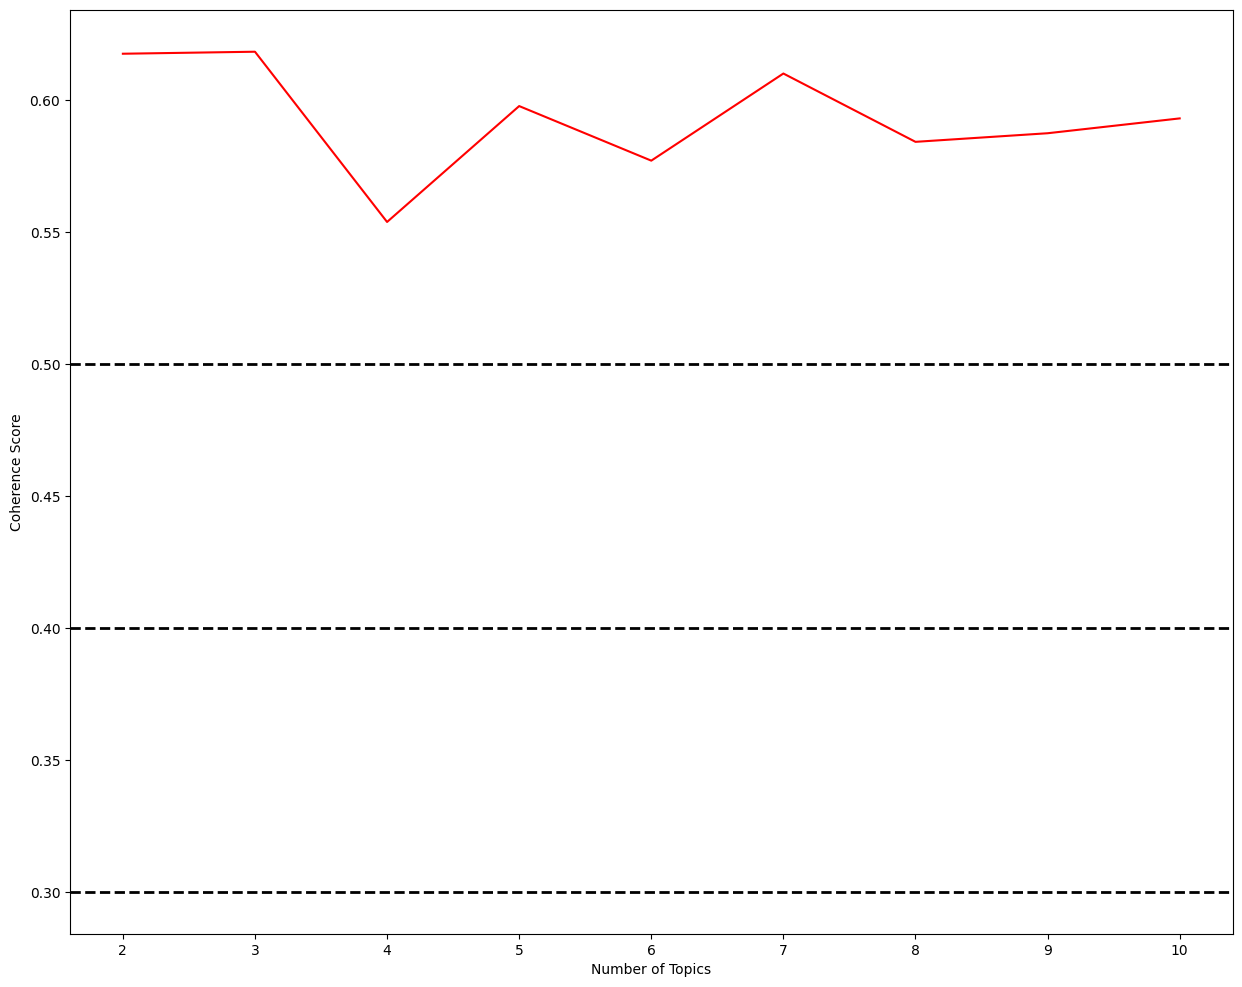

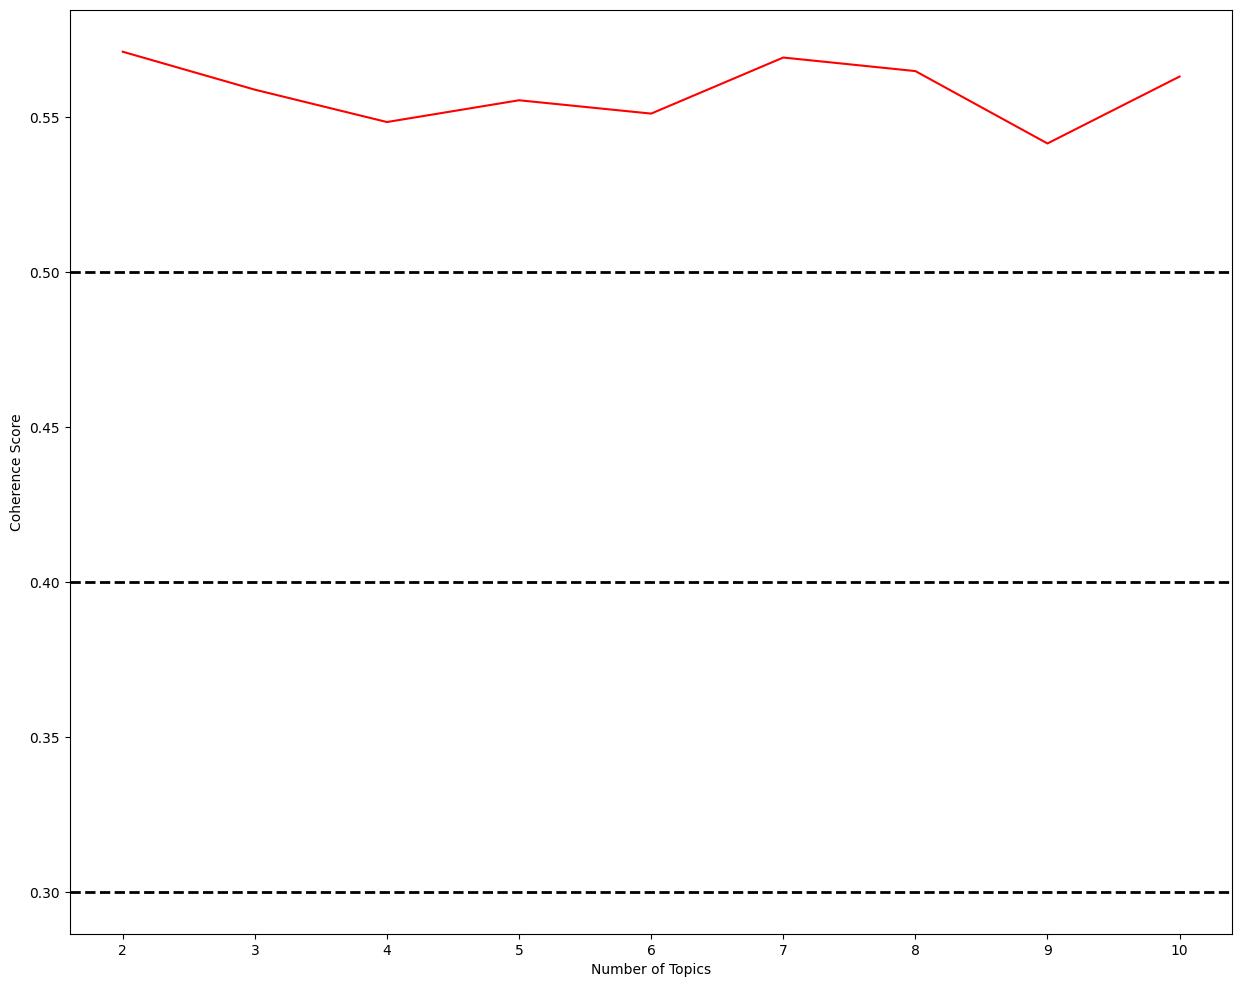

In [10]:
# Calculate coherence scores for each model
target_text = "review_cleaned_v1"

overall_coherence_df = pd.DataFrame() # df to store coherence_df
model_topic_info_list = []  # List to store model_topic_info

for i, df_set in enumerate(df_sets):
    
    print("\nDF NAME: {}\n".format(df_names[i]))

    coherence_df, model_topic_info = topic_model_coherence_plot(df_set, df_names[i], target_text, MODEL_NAMES, START_TOPIC_COUNT, END_TOPIC_COUNT)
    overall_coherence_df = pd.concat([overall_coherence_df, coherence_df], axis=0) # Concatenate to overall_coherence_df
    model_topic_info_list.append(model_topic_info) # Store model_topic_info in a list

In [11]:
# Print all models' coherence scores
overall_coherence_df

,Model Name,Number of Topics,Coherence Score,df_name
0,LSI,2,0.591727,df_pos
1,LSI,3,0.571082,df_pos
2,LSI,4,0.555712,df_pos
3,LSI,5,0.557853,df_pos
4,LSI,6,0.542620,df_pos
5,LSI,7,0.553892,df_pos
6,LSI,8,0.539608,df_pos
7,LSI,9,0.557802,df_pos
8,LSI,10,0.554632,df_pos
0,LDA,2,0.569075,df_pos


In [12]:
# Store coherence scores of all models into "overall_coherence_df", sort by "df_name" and "Coherence Score"
overall_coherence_df = overall_coherence_df.sort_values(["df_name", "Coherence Score"], ascending=False).reset_index(drop=True)
#overall_coherence_df

# Find best model for each df
overall_coherence_best_df = overall_coherence_df.loc[overall_coherence_df.groupby("df_name")["Coherence Score"].idxmax()].reset_index(drop=True)
overall_coherence_best_df

,Model Name,Number of Topics,Coherence Score,df_name
0,LSI,3,0.618340,df_neg
1,LDA,4,0.613102,df_pos


In [13]:
# Print topics of best model
print_best_model_topics(overall_coherence_best_df, model_topic_info_list)


DF NAME: df_neg
MODEL: LSI - NUMBER OF TOPICS: 3

Topic 1: I, room, hotel, stay, staff, check, one, night, get, go

Topic 2: room, I, small, hotel, night, staff, good, well, towel, clean

Topic 3: hotel, room, I, staff, stay, good, guest, really, day, location

----------


DF NAME: df_pos
MODEL: LDA - NUMBER OF TOPICS: 4

Topic 1: I, stay, hotel, staff, room, check, nice, would, place, get

Topic 2: room, hotel, I, small, stay, clean, good, shower, get, bed

Topic 3: location, hotel, good, great, room, staff, stay, near, clean, meet

Topic 4: room, clean, staff, good, stay, I, location, bed, nice, friendly

----------



In [14]:
end_time = datetime.now()
print("Text processing ended at {}".format(end_time))
print("Text processing spent {}".format(end_time - start_time))

Text processing ended at 2024-06-26 01:44:21.345429
Text processing spent 0:21:46.999901
